# **第6章: 機械学習**
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

# 50. データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．
1.   ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2.   情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3.   抽出された事例をランダムに並び替える．
4.   抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
#News Aggregator Data Set のインストールと解凍
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip ./NewsAggregatorDataset.zip

--2022-12-23 03:14:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  35.2MB/s    in 0.8s    

2022-12-23 03:14:36 (35.2 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  ./NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


・Pandasはデータ解析を容易にする機能を提供するpythonのデータ解析ライブラリ．
>  Pandasを使うメリット
1. 多種の型のデータを一つのデータフレームで扱えること\
NumPyの配列（np.array）はすべての要素が同じ型でなければならない．
よって、csvファイルの読み書きなどでは、NumPyは非常に不便なライブラリである．
その点、Pandasのデータフレームは異なる型のデータを入れることが出来る。
Pandasのデータフレームに格納することで、データの前処理が容易にできる。
2.データ加工や解析の関数が多いこと


・scikit-learnでデータを訓練用とテスト用に分割する
train_test_split
>  scikit-learnのtrain_test_split()関数を使うと、NumPy配列ndarrayやリストなどを二分割できる。機械学習においてデータを訓練用（学習用）とテスト用に分割してホールドアウト検証を行う際に用いる。\
引数test_size, train_sizeで割合，または個数を指定可能．デフォルトはtest_size=0.25\
引数shuffleでは要素をシャッフルするかを指定可能．

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

#データの読み込み
df = pd.read_csv('newsCorpora.csv', sep = '\t', header = None, names = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

#データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

#データの分割(学習，検証，評価データが80％，10％，10％になるように)
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True)
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True)

#ファイルに保存
train.to_csv('train.txt', sep='\t', index=False, header=None)
valid.to_csv('valid.txt', sep='\t', index=False, header=None)
test.to_csv('test.txt', sep='\t', index=False, header=None)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4500
e    4232
t    1223
m     717
Name: CATEGORY, dtype: int64
【検証データ】
b    590
e    499
t    145
m    100
Name: CATEGORY, dtype: int64
【評価データ】
e    548
b    537
t    156
m     93
Name: CATEGORY, dtype: int64


# 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

記事の見出しをスペースで分割した単語群を対象にTF-IDFを算出し、その値を特徴量として利用する.


In [3]:
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#前処理
def preprocessing(text):
    text = ''.join([i for i in text if not i in string.punctuation])    #記号を除去
    text = text.lower() #小文字化
    text = re.sub('[0-9]+', '', text)   #数字列を除去
    return text

#データの連結，前処理を行う
df = pd.concat([train, valid, test], axis=0)
df['TITLE'] = df['TITLE'].map(lambda x:preprocessing(x)) #各要素に関数を適用

#単語ベクトル化，Dataframeに変換
vec_tfidf = TfidfVectorizer()
data = vec_tfidf.fit_transform(df['TITLE'])
data = pd.DataFrame(data.toarray(), columns=vec_tfidf.get_feature_names())

#dataを3分割する
split_point_1 = int(len(data)//3)
split_point_2 = int(split_point_1*2)

#学習，検証，評価データ
x_train = data[:split_point_1]
x_valid = data[split_point_1:split_point_2]
x_test = data[split_point_2:]

#学習、検証、評価ラベル
y_data = df["CATEGORY"]
y_train = y_data[:split_point_1]
y_valid = y_data[split_point_1:split_point_2]
y_test = y_data[split_point_2:]

# 特徴量をファイルに保存する
x_train.to_csv('train.feature.txt', sep='\t', index=False)
x_valid.to_csv('valid.feature.txt', sep='\t', index=False)
x_test.to_csv('test.feature.txt', sep='\t', index=False)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [4]:
print(x_train.head())

    aa  aaa  aaliyah  aaliyahs  aaron  aatha  abandon  abandoned  abandoning  \
0  0.0  0.0      0.0       0.0    0.0    0.0      0.0        0.0         0.0   
1  0.0  0.0      0.0       0.0    0.0    0.0      0.0        0.0         0.0   
2  0.0  0.0      0.0       0.0    0.0    0.0      0.0        0.0         0.0   
3  0.0  0.0      0.0       0.0    0.0    0.0      0.0        0.0         0.0   
4  0.0  0.0      0.0       0.0    0.0    0.0      0.0        0.0         0.0   

   abating  ...  zone  zooey  zoosk   zs  zuckerberg  zynga  œfck  œlousyâ  \
0      0.0  ...   0.0    0.0    0.0  0.0         0.0    0.0   0.0      0.0   
1      0.0  ...   0.0    0.0    0.0  0.0         0.0    0.0   0.0      0.0   
2      0.0  ...   0.0    0.0    0.0  0.0         0.0    0.0   0.0      0.0   
3      0.0  ...   0.0    0.0    0.0  0.0         0.0    0.0   0.0      0.0   
4      0.0  ...   0.0    0.0    0.0  0.0         0.0    0.0   0.0      0.0   

   œpiece  œwaist  
0     0.0     0.0  
1     0.0 

# 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()    #ロジスティック会期モデルを実装
model.fit(x_train, y_train)     #第一引数に学習データ,第二引数にラベルを指定

LogisticRegression()

# 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [6]:
print(f"カテゴリ順：{model.classes_}\n")

Y_pred = model.predict(x_valid)     #.predict()メソッドでカテゴリを予測
print(f"各記事のカテゴリ（ラベル）：{y_valid.values}")
print(f"各記事のカテゴリ予測：{Y_pred}\n")

Y_pred = model.predict_proba(x_valid)       #.predict_proba()メソッドでカテゴリの予測確率を求める
print(f"カテゴリの予測確率：\n{Y_pred}")

カテゴリ順：['b' 'e' 'm' 't']

各記事のカテゴリ（ラベル）：['t' 't' 'b' ... 't' 'e' 'b']
各記事のカテゴリ予測：['e' 't' 'b' ... 't' 'e' 'b']

カテゴリの予測確率：
[[0.23145864 0.39155575 0.09501574 0.28196987]
 [0.20498939 0.29052224 0.06674403 0.43774434]
 [0.64465367 0.0783857  0.06370762 0.213253  ]
 ...
 [0.19435782 0.18977544 0.06642136 0.54944539]
 [0.23247203 0.59947021 0.0627216  0.10533616]
 [0.72326705 0.13453099 0.06966323 0.07253873]]


# 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [7]:
from sklearn.metrics import accuracy_score

#学習、評価データを予測
Y_pred_train = model.predict(x_train)
Y_pred_test = model.predict(x_test)     

#学習、評価データの正解率を求める（accuracy_score()を用いる）
print(f"train_accuracy：{accuracy_score(y_train, Y_pred_train)}")
print(f"test_accuracy：{accuracy_score(y_test, Y_pred_test)}")

train_accuracy：0.9239766081871345
test_accuracy：0.8264388489208633


# 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

混同行列（confusion matrix）はクラス分類問題の結果を「実際のクラス」と「予測したクラス」を軸にしてまとめたもの。\
第一引数に実際のクラス（正解クラス）、第二引数に予測したクラスのリストや配列を指定する。\
二値分類（2クラス分類）においては実際のクラスと予測したクラスの組み合わせによって、結果を以下の4種類に分けることができる。

>  真陽性（TP: True Positive）: 実際のクラスが陽性で予測も陽性（正解）\
真陰性（TN: True Negative）: 実際のクラスが陰性で予測も陰性（正解）\
偽陽性（FP: False Positive）: 実際のクラスは陰性で予測が陽性（不正解）\
偽陰性（FN: False Negative）: 実際のクラスは陽性で予測が陰性（不正解）

これを行列にしたものが混同行列

                     Predicted
                     Negative  Positive
    Actual Negative     TN        FP
           Positive     FN        TP

In [8]:
from sklearn.metrics import confusion_matrix

print(f"学習データの混同行列：\n{confusion_matrix(y_train, Y_pred_train)}\n")
print(f"評価データの混同行列：\n{confusion_matrix(y_test, Y_pred_test)}")

学習データの混同行列：
[[1842   19    0    7]
 [  10 1747    0    0]
 [  59   86  158    1]
 [  85   71    0  361]]

評価データの混同行列：
[[1737  111    1   12]
 [  51 1704    0    5]
 [ 118  123   71    4]
 [ 194  153    0  164]]


# 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

def metrics(y_data, y_pred, ave=None):
  precision_sco = precision_score(y_data, y_pred, average=ave)
  recall_sco = recall_score(y_data, y_pred, average=ave)
  f1_sco = f1_score(y_data, y_pred, average=ave)
  form = "適合率：{}\n再現率：{}\nF１：{}\n".format(precision_sco, recall_sco, f1_sco)
  return form

print(f"【カテゴリ順】{model.classes_}\n\n{metrics(y_test, Y_pred_test)}")
print("【マクロ平均】\n", metrics(y_test, Y_pred_test, "macro"))
print("【マイクロ平均】\n", metrics(y_test, Y_pred_test, "micro"))

【カテゴリ順】['b' 'e' 'm' 't']

適合率：[0.82714286 0.81492109 0.98611111 0.88648649]
再現率：[0.93336916 0.96818182 0.22468354 0.32093933]
F１：[0.87705125 0.88496494 0.36597938 0.47126437]

【マクロ平均】
 適合率：0.8786653862819573
再現率：0.6117934633727811
F１：0.6498149857785398

【マイクロ平均】
 適合率：0.8264388489208633
再現率：0.8264388489208633
F１：0.8264388489208633



# 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [10]:
import numpy as np

features = x_train.columns.values
for c, coef in zip(model.classes_, model.coef_):
  top_10 = pd.DataFrame(features[np.argsort(-coef)[:10]], columns=[f"重みの高い特徴量トップ10（クラス名：{c}）"], index=[i for i in range(1, 11)])
  worst_10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=[f"重みの低い特徴量トップ10（クラス名：{c}）"], index=[i for i in range(1, 11)])
  print( top_10, "\n"),
  print(worst_10, "\n", "-"*70)

   重みの高い特徴量トップ10（クラス名：b）
1                  china
2                 update
3                    ecb
4                   bank
5                     us
6                    fed
7                   euro
8                    buy
9                 shares
10                   oil 

   重みの低い特徴量トップ10（クラス名：b）
1                    the
2                    and
3                    her
4             kardashian
5               facebook
6                   star
7                    fda
8                  ebola
9                     tv
10                  have 
 ----------------------------------------------------------------------
   重みの高い特徴量トップ10（クラス名：e）
1             kardashian
2                    her
3                  chris
4                    kim
5                    she
6                  cyrus
7                  miley
8                     he
9                   film
10                  star 

   重みの低い特徴量トップ10（クラス名：e）
1                 update
2                     us
3                   say

# 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

【正則化パラメータ：0.001】

train_accuracy：0.42015294646873597
valid_accuracy：0.4269005847953216
test_accuracy：0.41839028776978415

【正則化パラメータ：0.025750000000000002】

train_accuracy：0.7690058479532164
valid_accuracy：0.7552856500224921
test_accuracy：0.7430305755395683

【正則化パラメータ：0.0505】

train_accuracy：0.7777777777777778
valid_accuracy：0.7678812415654521
test_accuracy：0.7565197841726619

【正則化パラメータ：0.07525000000000001】

train_accuracy：0.7813765182186235
valid_accuracy：0.7705802968960864
test_accuracy：0.7607913669064749

【正則化パラメータ：0.1】

train_accuracy：0.7838506522717049
valid_accuracy：0.7705802968960864
test_accuracy：0.7621402877697842



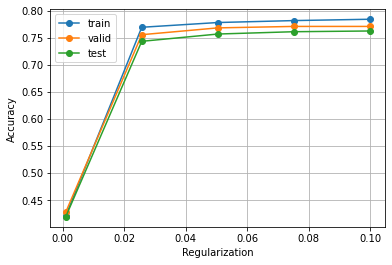

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#モデル構築、学習（関数）
def LR_model_fit(x_data, y_data, c):
  model = LogisticRegression(C=c)
  model.fit(x_data, y_data) 
  return model

#学習済みモデルを用いて予測する（関数）
def LR_pred(x_data, y_data, model):
  Y_pred_data = model.predict(x_data)
  accuracy = accuracy_score(Y_pred_data, y_data)
  return accuracy

train_acc = []
valid_acc = []
test_acc = []

#正則化パラメータ
c_list = np.linspace(0.001, 0.1, 5)

for c in c_list:
  model = LR_model_fit(x_train, y_train, c)
  pre_train = LR_pred(x_train, y_train, model)
  pre_valid = LR_pred(x_valid, y_valid, model)
  pre_test = LR_pred(x_test, y_test, model)

  train_acc.append(pre_train)
  valid_acc.append(pre_valid)
  test_acc.append(pre_test)

  print(f"【正則化パラメータ：{c}】\n")
  print(f"train_accuracy：{pre_train}")
  print(f"valid_accuracy：{pre_valid}")
  print(f"test_accuracy：{pre_test}\n")

#可視化
plt.plot(c_list, train_acc, label="train", marker="o")
plt.plot(c_list, valid_acc, label="valid", marker="o")
plt.plot(c_list, test_acc, label="test", marker="o")

plt.legend()
plt.grid(True)
plt.xlabel("Regularization")
plt.ylabel("Accuracy")
plt.show()

# 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [12]:
from sklearn.model_selection import GridSearchCV

params = {"C": [0.001, 0.005, 10]}

# グリッドサーチを行う
gs_model = GridSearchCV(LogisticRegression(max_iter=1500),params, cv=5, verbose=1)
gs_model.fit(x_train, y_train)

#最適なモデルを取得する
best_gs_model = gs_model.best_estimator_
print("\ntrain_score: {:.2%}".format(best_gs_model.score(x_train, y_train)))
print("valid_score: {:.2%}".format(best_gs_model.score(x_valid, y_valid)))
print("test_score: {:.2%}".format(best_gs_model.score(x_test, y_test)))

Fitting 5 folds for each of 3 candidates, totalling 15 fits

train_score: 99.96%
valid_score: 87.70%
test_score: 87.41%
